In [1]:
import os
import re

import numpy as np
import pandas as pd

import igraph as ig
import leidenalg as la

import sqlite3

from sklearn.preprocessing import StandardScaler
import umap

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import measure, io
from skimage.morphology import label

from cellutils.utils import get_data_cols

import pickle

dt = pd.read_csv("test_data.csv")

with open('test_data_cols', 'rb') as f:
    data_cols = pickle.load(f)

### Data ###
db = "/mnt/sextonlabdata/Active_Users_Data/Max/DILI/HDS_Screens_Pooled/65C_AllHDS_042025/Morphology/PerCell/HepG2_Plate1_Morphology.sqlite"
img_dir = '/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/'
############

def bounding_crop(dna_img, cell_img, target_img, mask_img, center_x, center_y, x_min, x_max, y_min, y_max):
    # mask_label = label(mask_image)
    # props = measure.regionprops(mask_label)
    y1 = center_y-y_min
    y2 = center_y+y_max
    x1 = center_x-x_min
    x2 = center_x+x_max
    crop_dna = dna_image[x1:x2, y1:y2]
    crop_cmo = cmo_image[x1:x2, y1:y2]
    crop_target = target_image[x1:x2, y1:y2]
    return np.stack([crop_dna, crop_cmo, crop_target], axis=0)

def get_crops(df, img_dir, mask_dir, output_dir, diam_col, 
              diam_val=100, cluster_col='leiden_cluster', obj_num_col='ObjectNumber',
              well_col='Image_Metadata_WellID', field_col='Image_Metadata_Field',
              chan1='C01', chan2='C02', chan3='C03', mask_chan='C01'):
    dt = df.loc[df[diam_col]>diam_val] # filter df to cells with diameter > diam_val
    dt = sample_df(dt, cluster_col) # randomly pull n samples from each cluster group
    for ind, row in tqdm.tqdm(dt.iterrows()):
        wid = row[well_col]
        fid = row[field_col]
        obj_num = row[obj_num_col]
        
        img_c1 = io.imread(get_img_path(mask_path=img_dir, well_id=wid, field_id=fid, channel=chan1))
        img_c2 = io.imread(get_img_path(mask_path=img_dir, well_id=wid, field_id=fid, channel=chan2))
        img_c3 = io.imread(get_img_path(mask_path=img_dir, well_id=wid, field_id=fid, channel=chan3))
        mask = io.imread(get_img_path(mask_path=mask_dir, well_id=wid, field_id=fid, channel=mask_chan))
        crop_img = crop_image(img_c1, img_c2, img_c3, mask,obj_num)
        fname = os.path.join(output_dir, f"cluster_{row[cluster_col]}_object_{ind}.tif")
        io.imsave(fname, crop_img)

2025-06-23 10:48:39.209557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-23 10:48:39.261242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-23 10:48:39.275529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 10:48:39.362077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-23 10:48:40.327586: W tensorflow/compiler/tf2

In [2]:
con = sqlite3.connect(db)
df = pd.read_sql_query("SELECT * FROM Per_Object", con)

In [3]:
meta_cols = df.columns[df.columns.str.contains(pat="Location|Center|Children|Parent|Scaling|ExecutionTime")].tolist()
data_cols = df.drop(columns=meta_cols).select_dtypes(include='float64').columns.tolist()

In [4]:
for c in data_cols:
    print(c)

Cell_AreaShape_Area
Cell_AreaShape_BoundingBoxArea
Cell_AreaShape_BoundingBoxMaximum_X
Cell_AreaShape_BoundingBoxMaximum_Y
Cell_AreaShape_BoundingBoxMinimum_X
Cell_AreaShape_BoundingBoxMinimum_Y
Cell_AreaShape_Compactness
Cell_AreaShape_ConvexArea
Cell_AreaShape_Eccentricity
Cell_AreaShape_EquivalentDiameter
Cell_AreaShape_EulerNumber
Cell_AreaShape_Extent
Cell_AreaShape_FormFactor
Cell_AreaShape_MajorAxisLength
Cell_AreaShape_MaxFeretDiameter
Cell_AreaShape_MaximumRadius
Cell_AreaShape_MeanRadius
Cell_AreaShape_MedianRadius
Cell_AreaShape_MinFeretDiameter
Cell_AreaShape_MinorAxisLength
Cell_AreaShape_Orientation
Cell_AreaShape_Perimeter
Cell_AreaShape_Solidity
Cell_AreaShape_Zernike_0_0
Cell_AreaShape_Zernike_1_1
Cell_AreaShape_Zernike_2_0
Cell_AreaShape_Zernike_2_2
Cell_AreaShape_Zernike_3_1
Cell_AreaShape_Zernike_3_3
Cell_AreaShape_Zernike_4_0
Cell_AreaShape_Zernike_4_2
Cell_AreaShape_Zernike_4_4
Cell_AreaShape_Zernike_5_1
Cell_AreaShape_Zernike_5_3
Cell_AreaShape_Zernike_5_5
Cell_A

In [5]:
X = StandardScaler().fit_transform(df[data_cols])

In [6]:
embedder = umap.UMAP(random_state=42)

In [7]:
df[['umap_1', 'umap_2']] = embedder.fit_transform(X)

/home/ben/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Axes: xlabel='umap_1', ylabel='umap_2'>

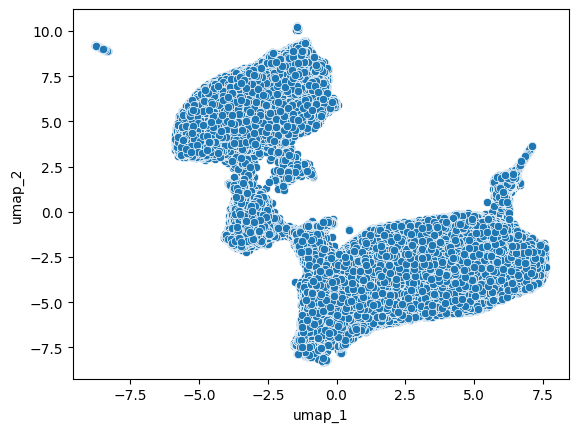

In [8]:
sns.scatterplot(data=df, x='umap_1', y='umap_2')

In [9]:
df.shape

(419096, 291)

In [10]:
df['Cell_AreaShape_Area'].mean(), df['Cell_AreaShape_Area'].min(), df['Cell_AreaShape_Area'].max(), df['Cell_AreaShape_Area'].std()

(1158.1371929104548, 15.0, 1333525.0, 3456.9782776477027)

In [11]:
df['Cell_AreaShape_BoundingBoxArea'].mean(), df['Cell_AreaShape_BoundingBoxArea'].min(), df['Cell_AreaShape_BoundingBoxArea'].max(), df['Cell_AreaShape_BoundingBoxArea'].std(), 

(2903.2203385381868, 24.0, 2865132.0, 11116.043474289652)

In [19]:
possibles = df.loc[df['Cell_AreaShape_BoundingBoxArea']>(3*11116)+2903]

In [21]:
temp = possibles.iloc[1]

In [22]:
temp['Cell_AreaShape_BoundingBoxMaximum_X'], temp['Cell_AreaShape_BoundingBoxMinimum_X'], temp['Cell_AreaShape_BoundingBoxMaximum_Y'], temp['Cell_AreaShape_BoundingBoxMinimum_Y'], 

(527.0, 329.0, 1956.0, 1753.0)

In [23]:
temp['ImageNumber']

21.0

In [24]:
img = pd.read_sql_query("SELECT * FROM Per_Image", con)

In [25]:
img.shape

(3456, 674)

In [26]:
img.head()

,ImageNumber,Image_Count_Cell,Image_Count_Nuclei,Image_ExecutionTime_01Images,Image_ExecutionTime_02Metadata,Image_ExecutionTime_03NamesAndTypes,Image_ExecutionTime_04Groups,Image_ExecutionTime_05IdentifySecondaryObjects,Image_ExecutionTime_06MeasureTexture,Image_ExecutionTime_07MeasureGranularity,...,Mean_Nuclei_AreaShape_Zernike_8_6,Mean_Nuclei_AreaShape_Zernike_8_8,Mean_Nuclei_AreaShape_Zernike_9_1,Mean_Nuclei_AreaShape_Zernike_9_3,Mean_Nuclei_AreaShape_Zernike_9_5,Mean_Nuclei_AreaShape_Zernike_9_7,Mean_Nuclei_AreaShape_Zernike_9_9,Mean_Nuclei_Children_Cell_Count,Mean_Nuclei_Location_Center_X,Mean_Nuclei_Location_Center_Y
0,1,94,94,0.0,0.0,1.656250,0.0,1.171875,0.703125,15.734375,...,0.009191,0.007800,0.006755,0.006860,0.006730,0.006823,0.005044,1.0,1037.501549,1128.192435
1,2,48,48,0.0,0.0,2.203125,0.0,1.984375,1.437500,29.468750,...,0.007861,0.009008,0.007016,0.006269,0.006634,0.005928,0.005542,1.0,661.217697,920.458529
2,3,59,59,0.0,0.0,2.281250,0.0,2.109375,1.281250,28.593750,...,0.008029,0.009704,0.005578,0.006127,0.006941,0.006096,0.005375,1.0,787.809479,913.328143
3,4,100,100,0.0,0.0,2.625000,0.0,2.406250,1.140625,28.953125,...,0.009024,0.009718,0.006665,0.007591,0.007414,0.007329,0.005468,1.0,1149.068604,926.580530
4,5,151,151,0.0,0.0,2.250000,0.0,2.250000,1.343750,28.093750,...,0.008284,0.009688,0.006288,0.006365,0.006092,0.006072,0.004804,1.0,901.828770,1027.020000


In [27]:
target = img.loc[img['ImageNumber']== 21]
target.shape

(1, 674)

In [28]:
target

,ImageNumber,Image_Count_Cell,Image_Count_Nuclei,Image_ExecutionTime_01Images,Image_ExecutionTime_02Metadata,Image_ExecutionTime_03NamesAndTypes,Image_ExecutionTime_04Groups,Image_ExecutionTime_05IdentifySecondaryObjects,Image_ExecutionTime_06MeasureTexture,Image_ExecutionTime_07MeasureGranularity,...,Mean_Nuclei_AreaShape_Zernike_8_6,Mean_Nuclei_AreaShape_Zernike_8_8,Mean_Nuclei_AreaShape_Zernike_9_1,Mean_Nuclei_AreaShape_Zernike_9_3,Mean_Nuclei_AreaShape_Zernike_9_5,Mean_Nuclei_AreaShape_Zernike_9_7,Mean_Nuclei_AreaShape_Zernike_9_9,Mean_Nuclei_Children_Cell_Count,Mean_Nuclei_Location_Center_X,Mean_Nuclei_Location_Center_Y
20,21,51,51,0.0,0.0,2.0,0.0,2.4375,1.125,30.640625,...,0.008891,0.009843,0.005821,0.006548,0.006534,0.005593,0.00469,1.0,1172.594081,1037.900706


In [29]:
target['Image_FileName_DNA']

20    PECCU_A03_T0001F003L01A01Z01C01.tif
Name: Image_FileName_DNA, dtype: object

In [40]:
temp

ImageNumber                          21.000000
ObjectNumber                         47.000000
Cell_Number_Object_Number            47.000000
Cell_AreaShape_Area                5153.000000
Cell_AreaShape_BoundingBoxArea    40194.000000
                                      ...     
Nuclei_Children_Cell_Count            1.000000
Nuclei_Location_Center_X            375.046099
Nuclei_Location_Center_Y           1802.063830
umap_1                               -1.168524
umap_2                                9.296572
Name: 1878, Length: 291, dtype: float64

In [35]:
dna = '/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/PECCU/PECCU_A03_T0001F003L01A01Z01C01.tif'
cell = '/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/PECCU/PECCU_A03_T0001F003L01A02Z01C02.tif'
target = '/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/PECCU/PECCU_A03_T0001F003L01A01Z01C03.tif'
mask = '/mnt/instrumentdata/CV8000/Max/65C-ALLHDS_20250425_141329_Plate1/Masks/PECCU_A03_T0001F003L01A01Z01C01.tif'

In [36]:
dna = io.imread(dna)
cell = io.imread(cell)
target = io.imread(target)
mask = io.imread(mask)

In [75]:
def bounding_crop(dna_img, cell_img, target_img, mask_img,  xmin, xmax, ymin, ymax):
    crop_dna = dna_img[ymin:ymax, xmin:xmax]
    crop_cmo = cell_img[ymin:ymax, xmin:xmax]
    crop_target = target_img[ymin:ymax, xmin:xmax]
    return np.stack((crop_dna, crop_cmo, crop_target), axis=0)

In [42]:
temp['Cell_AreaShape_BoundingBoxMinimum_X'],temp['Cell_AreaShape_BoundingBoxMaximum_X'],temp['Cell_AreaShape_BoundingBoxMinimum_Y'],temp['Cell_AreaShape_BoundingBoxMaximum_Y'],

(329.0, 527.0, 1753.0, 1956.0)

In [66]:
xmin = 329
xmax = 527
ymin = 1753 
ymax = 1956


In [76]:
cropped = bounding_crop(dna, cell, target, mask , xmin, xmax, ymin, ymax)

In [77]:
cropped.shape

(3, 203, 198)

In [84]:
temp['Cell_Location_Center_Y']

1866.522220065981

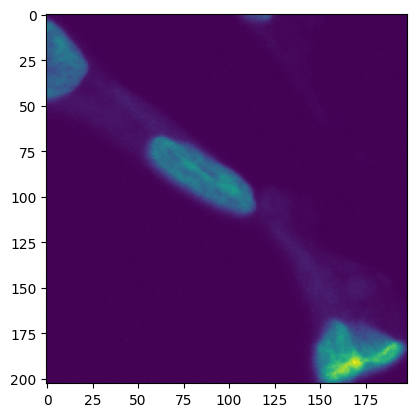

In [74]:
plt.imshow(dna[ymin:ymax, xmin:xmax])

In [83]:
io.imsave('test.tif', cropped)

In [70]:
dna.shape

(1998, 1998)

In [71]:
test = dna[xmin:xmax, ymin:ymax]

In [72]:
test.shape

(198, 203)

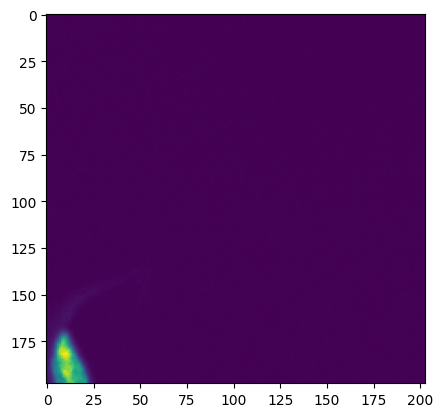

In [73]:
plt.imshow(test)

In [89]:
target = img.loc[img['ImageNumber']== 21]

In [91]:
target['Image_FileName_DNA']

20    PECCU_A03_T0001F003L01A01Z01C01.tif
Name: Image_FileName_DNA, dtype: object

In [93]:
image_cols = target.columns[target.columns.str.contains(pat='FileName')].tolist()
image_cols

['Image_FileName_DNA',
 'Image_FileName_LipidTox',
 'Image_FileName_Mitotracker',
 'Image_FileName_WholeCell',
 'Image_ObjectsFileName_Nuclei']

In [94]:
for c in image_cols:
    print(target[c])

20    PECCU_A03_T0001F003L01A01Z01C01.tif
Name: Image_FileName_DNA, dtype: object
20    PECCU_A03_T0001F003L01A03Z01C04.tif
Name: Image_FileName_LipidTox, dtype: object
20    PECCU_A03_T0001F003L01A02Z01C02.tif
Name: Image_FileName_Mitotracker, dtype: object
20    PECCU_A03_T0001F003L01A01Z01C03.tif
Name: Image_FileName_WholeCell, dtype: object
20    PECCU_A03_T0001F003L01A01Z01C01.tif
Name: Image_ObjectsFileName_Nuclei, dtype: object
